In [1]:
import numpy as np
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

In [2]:
sys.path.append("D:\Master Thesis\library")
for i in range(len(sys.path)): print(sys.path[i])

D:\NJU_intern\ErrSig\20210528
C:\Users\Administrator\anaconda3\python38.zip
C:\Users\Administrator\anaconda3\DLLs
C:\Users\Administrator\anaconda3\lib
C:\Users\Administrator\anaconda3

C:\Users\Administrator\anaconda3\lib\site-packages
C:\Users\Administrator\anaconda3\lib\site-packages\win32
C:\Users\Administrator\anaconda3\lib\site-packages\win32\lib
C:\Users\Administrator\anaconda3\lib\site-packages\Pythonwin
C:\Users\Administrator\anaconda3\lib\site-packages\IPython\extensions
C:\Users\Administrator\.ipython
D:\Master Thesis\library


In [3]:
import fitting.fitting as fitting

In [4]:
def Lorentzian(x, x0, fwhm, amp, offset):
    return amp*fwhm**2/((x-x0)**2 + fwhm**2) + offset
def Lorentzian_fit(x, y, x0 = 0, fwhm = 1, amp = 1, offset = 0):
    #print(x0)
    model = Lorentzian
    fitp = fitting.fit(model, x, y, x0=x0, fwhm = fwhm, amp = amp, offset= offset)
    return fitp
def Lorentzian_slope(x, x0, fwhm, amp, offset, slope):
    return amp*fwhm**2/((x-x0)**2 + fwhm**2) + offset + slope*(x-x0)
def Lorentzian_slope_fit(x, y, x0 = 0, fwhm = 1, amp = 1, offset = 0, slope=0):
    #print(x0)
    model = Lorentzian_slope
    fitp = fitting.fit(model, x, y, x0=x0, fwhm = fwhm, amp = amp, offset= offset, slope=slope)
    return fitp

def Linear_func(x, offset, slope):
    return slope*(x - offset)

def Linear_fit(x, y, offset =0, slope =1):
    model = Linear_func
    fitp = fitting.fit(model, x, y, offset= offset, slope=slope)
    return fitp

def Err_sig_for_fit(freq, f0, imbal_phase, slope, offset, amp=0.1, r = np.sqrt(0.95), aft_loss = 0.887):
    t = np.sqrt(1- r**2)
    L = 2
    c = 299792458
    n = 1.5
    
    aft_loss_E = np.sqrt(aft_loss)
    
    add_phase = n*(freq - f0)*1e6*L/c*2*np.pi
    
    E_out = r - t**2*np.exp(-1j*add_phase)/(1 - aft_loss_E*r*np.exp(-1j*add_phase))
    
    err_sig = -1*E_out.imag*np.cos(imbal_phase) - E_out.real*np.sin(imbal_phase)
    
    err_sig = amp*err_sig + slope*(freq - f0) + offset
    return err_sig

def Err_sig_fit(freq, err_sig, f0, imbal_phase, amp=0.1, slope= 0, offset=0):
    model = Err_sig_for_fit
    fitp = fitting.fit(model, freq, err_sig, f0= f0, imbal_phase = imbal_phase, amp = amp
                       , slope = slope, offset= offset)
    return fitp

def get_err_sig(delta_L =0, aft_loss = 0.99, r = np.sqrt(0.95), L= 2, c=299792458, n=1.5, Omega = 1e8, denominator =20, num_points = 1000,
               demodulator = True):
    t = np.sqrt(1- r**2)
    fsr =c/n/L
    delta_omega = np.linspace(- fsr/denominator, fsr/denominator, num_points)
    add_phse = n*delta_omega*L/c*2*np.pi
    imbal_phase = n*Omega*delta_L/c
    aft_loss_E = np.sqrt(aft_loss)
    
    E_out = r - t**2*np.exp(-1j*add_phse)/(1 - aft_loss_E*r*np.exp(-1j*add_phse))
    if demodulator:
        err_sig = -1*E_out.imag*np.cos(imbal_phase) - E_out.real*np.sin(imbal_phase)
    else:
        err_sig = E_out.real*np.cos(imbal_phase) - E_out.imag*np.sin(imbal_phase)
    return delta_omega, err_sig, E_out

def get_transmission(freq, f0, aft_loss_E, offset=0, slope=0, amp=1, R = 0.95, T = 0.05):
    n = 1.5
    L = 2
    c = 299792458
    t = np.sqrt(T)
    r = np.sqrt(R)
    delta_omega = (freq - f0)*1e6
    add_phse = n*delta_omega*L/c*2*np.pi
    E_out = r - t**2*np.exp(-1j*add_phse)/(1 - aft_loss_E*r*np.exp(-1j*add_phse))
    I_final = amp*np.real(E_out*np.conj(E_out)) + offset + slope*(freq - f0)
    return I_final

def transmission_fit(freq, trans, f0, aft_loss_E, offset, slope, amp):
    model = get_transmission
    fitp = fitting.fit(model, freq, trans, f0= f0, aft_loss_E = aft_loss_E, offset = offset, slope = slope, amp =amp)
    return fitp

In [5]:
Err_sig_for_fit(12e6, 10e6, np.pi/10, aft_loss = 0.886, slope = 0.1, offset = 0.1, r = np.sqrt(0.95))
get_transmission(12e6, 10e6, 0.95, R = 0.95, T = 0.05)

0.9964476956319311

In [6]:
def flatten_data(data):
    slope=(data[-1] - data[0])/len(data)
    for i in range(len(data)):
        data[i] = data[i] - slope*i
    return data

In [7]:
def load_data(directory):
    data = []
    variance = []
    var_interval = 2
    k = 0
    for i in range(len(directory)): 
        data.append(np.loadtxt(directory[i]))
        _variance = np.zeros(len(data[k]))
        for j in range(len(data[k])):
            if j >=var_interval and j+var_interval <= len(data[k])-1:
                _variance[j] = np.var(data[k][j-var_interval:j+var_interval])
            if j <var_interval:
                _variance[j] = np.var(data[k][j:j+var_interval*2])
            if j+var_interval > len(data[k])-1:
                _variance[j] = np.var(data[k][j-var_interval*2:-1])
        k = k+1
        variance.append(_variance)
    return data, variance

In [10]:
directory = []
scan_range = 80
timing = np.arange(-90, 210, 30)
for i in timing:
    directory.append("D:/NJU_intern/ErrSig/20210528/phase_{}2.dat".format(i))
t, variance_t= load_data(directory)
print(len(directory))
print(len(t))

10
10


In [12]:
directory_e = []
timing = np.arange(-90, 210, 30)
for i in timing:
    directory_e.append("D:/NJU_intern/ErrSig/20210528/phase_{}3.dat".format(i))
data_e, variance_e= load_data(directory_e)

In [76]:
directory_ref = []
timing = [1]
for i in timing:
    directory_ref.append("D:/NJU_intern/ErrSig/20210525/20210525fiber_cavity_TEC_ref_{}.dat".format(i))
data_ref, variance_ref= load_data(directory_ref)

In [237]:
x = np.arange(len(data_e[-2]))/20
print(x)

[0.000e+00 5.000e-02 1.000e-01 ... 5.005e+01 5.010e+01 5.015e+01]


<IPython.core.display.Javascript object>


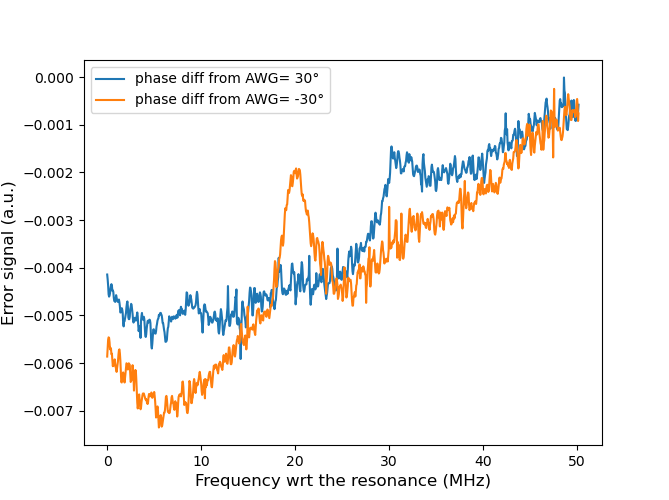

In [238]:
fig = plt.figure()
ax = fig.add_subplot(111)

phase = np.arange(-90, 210, 30)
for i in [4,2]:
    ax.plot(x, t[i], label = "phase diff from AWG= {}°".format(phase[i]))
    
ax.set_xlabel("Frequency wrt the resonance (MHz)", FontSize =12)
ax.set_ylabel("Error signal (a.u.)", FontSize =12)
ax.legend()

In [240]:
def get_transmission(freq, f0, aft_loss_E, offset=0, slope=0, amp=1, R = 0.95, T = 0.05):
    n = 1.5
    L = 2
    c = 299792458
    t = np.sqrt(T)
    r = np.sqrt(R)
    delta_omega = (freq - f0)
    add_phse = n*delta_omega*L/c*2*np.pi
    E_out = r - t**2*np.exp(-1j*add_phse)/(1 - aft_loss_E*r*np.exp(-1j*add_phse))
    I_final = amp*np.real(E_out*np.conj(E_out)) + offset + slope*(freq - f0)
    return I_final

def get_err_sig(freq, f0, aft_loss_E=1, offset=0, slope=0, amp=1, T=0.05, R=0.95, n=1.5, c= 299792458):
    L= 2
    I_final = get_transmission(freq=freq, f0=f0, aft_loss_E =aft_loss_E, R = R, T = T)
    err_sig = T*np.sin(n*(freq -f0)*L/c)/(1+ R*aft_loss_E**2 - 2*np.sqrt(R)*aft_loss_E*np.cos(n*(freq -f0)*L/c))
    err_sig = amp*np.sqrt(I_final)*err_sig + (freq-f0)*slope + offset
    return err_sig

<IPython.core.display.Javascript object>


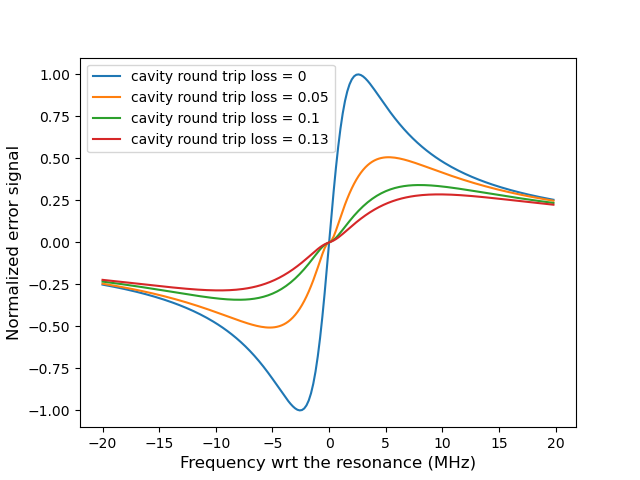

In [241]:
fig = plt.figure()
ax = fig.add_subplot(111)

freq = np.arange(-2e7,2e7, 2e5)
f0 = 0

loss_E = [1, 0.95, 0.90, 0.87]

for i in aft_loss_E:
    
    err_sig = get_err_sig(freq, f0, aft_loss_E = np.sqrt(i), slope=0, amp=1)

    ax.plot(freq*1e-6, err_sig, label ="cavity round trip loss = {}".format(round(1-i,3)))
ax.set_xlabel("Frequency wrt the resonance (MHz)", FontSize =12)
ax.set_ylabel("Normalized error signal", FontSize =12)
ax.legend()

25.579449096682417
0.9877287962301663


<IPython.core.display.Javascript object>


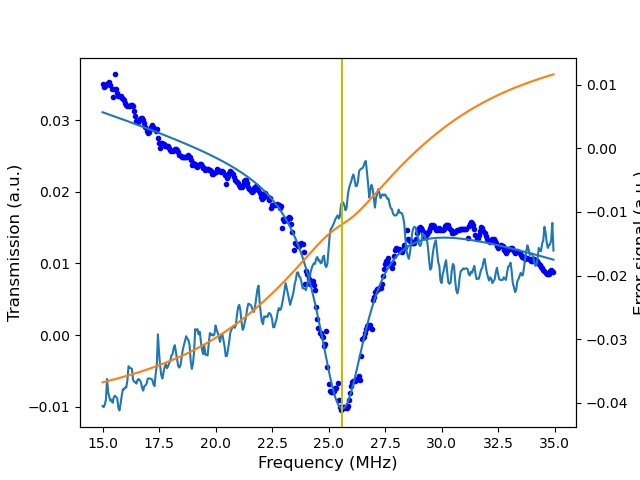

Text(0, 0.5, 'Transmission (a.u.)')

In [248]:
j=1

fitp = Lorentzian_slope_fit(x[300:700],data_e[j][300:700]
                                , x0 = 35, fwhm = 10, amp = -1, offset = 0, slope=-0.001)
print(fitp["x0"])

freq_per_point = 1.36/fitp["fwhm"]
print(1/freq_per_point)

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(x,t[3]*10,'r.')
ax2 = ax.twinx()


ax.plot(x[300:700], data_e[j][300:700], 'b.')
ax2.plot(x[300:700],t[j][300:700]*10)

err_sig = get_err_sig(x[300:700]*1e6, fitp["x0"]*1e6, aft_loss_E = np.sqrt(0.87), offset=-0.012, slope= 1e-9, amp=0.05)
ax2.plot(x[300:700],err_sig)

plt.axvline(fitp["x0"],color='y')
ax.plot(fitp["fitx"], fitp["fity"])

ax.set_xlabel("Frequency (MHz)", FontSize =12)
ax2.set_ylabel("Error signal (a.u.)", FontSize =12)
ax.set_ylabel("Transmission (a.u.)", FontSize =12)

<IPython.core.display.Javascript object>


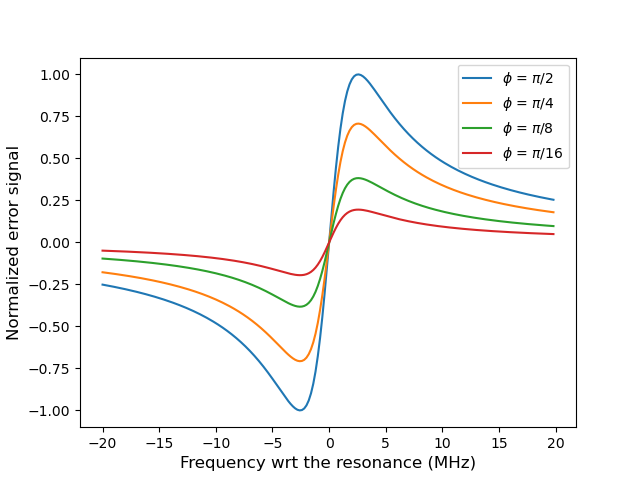

In [243]:
fig = plt.figure()
ax = fig.add_subplot(111)

freq = np.arange(-2e7,2e7, 2e5)
f0 = 0

phi = [np.pi/2, np.pi/4, np.pi/8, np.pi/16]

for i in phi:
    
    err_sig = get_err_sig(freq, f0, aft_loss_E = 1, slope=0, amp=1)*np.sin(i)

    ax.plot(freq*1e-6, err_sig, label ="$\phi$ = $\pi$/{}".format(int(np.pi/i)))
ax.set_xlabel("Frequency wrt the resonance (MHz)", FontSize =12)
ax.set_ylabel("Normalized error signal", FontSize =12)
ax.legend()